In [1]:
from segment2d import *
import numpy as np
import csv
from matplotlib import pyplot as plt
from ipywidgets import interact
# visualize the image and mask in z ax is using interact, image and mask are in one slice
import SimpleITK as sitk
import scipy.ndimage as ndimage
from metrics_segmentation import hd
from natsort import natsorted
import configparser
from pathlib import Path
import pandas as pd
import os

# predict emidec


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with open("csv_files/EMIDEC_test_train_full.csv", mode="r") as f:
    reader = csv.DictReader(f)
    list_test_subject = [row["path"] for row in reader]

model_emidec = torch.load("tiramisu_emidec.pt", weights_only=False)
model_emidec.eval()
model_emidec = model_emidec.to(device)

/home/nhattm/.conda/envs/tomodl/lib/python3.10/site-packages/torch/cuda/__init__.py:58: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [ ]:
import time
import torch
import pynvml  # nvidia-ml-py

def measure_energy_nvml(model, input_tensor, device='cuda:0', sample_interval=0.01, num_warmup=3):
    """
    Measure energy consumption (Joules) for a PyTorch operation using nvidia-ml-py.
    
    Args:
        model: PyTorch model (nn.Module).
        input_tensor: Input tensor (e.g., shape (1, C, H, W) for a single patient prediction).
        device: CUDA device (e.g., 'cuda:0').
        sample_interval: Time between power samples (seconds; default 10ms for accuracy).
        num_warmup: Number of dry runs to stabilize GPU (default 3).
    
    Returns:
        dict: {'energy_joules': float, 'avg_power_w': float, 'inference_time_s': float}
    """
    # Initialize NVML
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(int(device.split(':')[-1]))
    
    # Warmup runs to stabilize GPU clocks
    model.eval().to(device)
    input_tensor = input_tensor.to(device)
    with torch.no_grad():
        for _ in range(num_warmup):
            _ = model(input_tensor)
    torch.cuda.synchronize()  # Ensure warmup completes
    
    # Power sampling during inference
    power_samples = []
    start_time = time.time()
    
    with torch.no_grad():
        torch.cuda.synchronize()  # Sync before start
        start_sample = time.time()
        output = model(input_tensor)
        torch.cuda.synchronize()  # Sync after end
        end_sample = time.time()
    
    inference_time = end_sample - start_sample
    
    # Sample power during the inference window (high-frequency polling)
    sample_start = start_time
    while sample_start < end_sample:
        power_mw = pynvml.nvmlDeviceGetPowerUsage(handle)
        power_samples.append(power_mw / 1000.0)  # Convert to Watts
        time.sleep(sample_interval)
        sample_start += sample_interval
    
    avg_power = sum(power_samples) / len(power_samples) if power_samples else 0.0
    energy_joules = avg_power * inference_time
    
    # Cleanup
    pynvml.nvmlShutdown()
    
    return {
        'energy_joules': energy_joules,
        'avg_power_w': avg_power,
        'inference_time_s': inference_time
    }

Inference time: 9.0607 s
Average power: 18.69 W
Energy per prediction: 169.3440 J


In [3]:
import time
import torch
import pynvml  # nvidia-ml-py

def measure_energy_nvml(model, input_tensor, device='cuda:0', sample_interval=0.01, num_warmup=3):
    """
    Measure energy consumption (Joules) for a PyTorch operation using nvidia-ml-py.
    
    Args:
        model: PyTorch model (nn.Module).
        input_tensor: Input tensor (e.g., shape (1, C, H, W) for a single patient prediction).
        device: CUDA device (e.g., 'cuda:0').
        sample_interval: Time between power samples (seconds; default 10ms for accuracy).
        num_warmup: Number of dry runs to stabilize GPU (default 3).
    
    Returns:
        dict: {'energy_joules': float, 'avg_power_w': float, 'inference_time_s': float}
    """
    # Initialize NVML
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(int(device.split(':')[-1]))
    
    # Warmup runs to stabilize GPU clocks
    model.eval().to(device)
    input_tensor = input_tensor.to(device)
    with torch.no_grad():
        for _ in range(num_warmup):
            _ = model(input_tensor)
    torch.cuda.synchronize()  # Ensure warmup completes
    
    # Power sampling during inference
    power_samples = []
    start_time = time.time()
    
    with torch.no_grad():
        torch.cuda.synchronize()  # Sync before start
        start_sample = time.time()
        output = model(input_tensor)
        torch.cuda.synchronize()  # Sync after end
        end_sample = time.time()
    
    inference_time = end_sample - start_sample
    
    # Sample power during the inference window (high-frequency polling)
    sample_start = start_time
    while sample_start < end_sample:
        power_mw = pynvml.nvmlDeviceGetPowerUsage(handle)
        power_samples.append(power_mw / 1000.0)  # Convert to Watts
        time.sleep(sample_interval)
        sample_start += sample_interval
    
    avg_power = sum(power_samples) / len(power_samples) if power_samples else 0.0
    energy_joules = avg_power * inference_time
    
    # Cleanup
    pynvml.nvmlShutdown()
    
    return {
        'energy_joules': energy_joules,
        'avg_power_w': avg_power,
        'inference_time_s': inference_time
    }
    
patient_input = torch.randn(1, 1, 256, 256)  # Example: single-channel 256x256 MRI slice

# Measure
results = measure_energy_nvml(model_emidec, patient_input)
print(f"Energy per patient prediction: {results['energy_joules']:.4f} J")
print(f"Average power: {results['avg_power_w']:.2f} W")
print(f"Inference time: {results['inference_time_s']:.4f} s")

Energy per patient prediction: 0.3861 J
Average power: 34.08 W
Inference time: 0.0113 s


In [22]:
import pynvml

metrics_emidec_header = ["patient_name", 
    "Dice_Myocardium","HD_Myocardium", "Volume_Myocardium", "Err_Myocardium(ml)",
    "Dice_Infarction", "Volume_Infarction", "Err_Infarction(ml)", "Vol_Difference_Infarction_rate(%)",
    "Dice_No-Reflow", "Volume_No-Reflow", "Err_No-Reflow(ml)", "Vol_Difference_No-Reflow_rate(%)",
    ]
# create folder to save the predicted image
os.makedirs("predicted_emidec", exist_ok=True)

with open("csv_files/EMIDEC_test_train_full.csv", mode="r") as f:
    reader = csv.DictReader(f)
    list_test_subject = [row["path"] for row in reader]
# open csv file to save the result
f = open("csv_files/result_emidec.csv", mode="w")
writer = csv.DictWriter(f, fieldnames=metrics_emidec_header)
writer.writeheader()

#open csv file to save the volume of GT
f_volume = open("csv_files/volume_emidec_GT.csv", mode="w")
writer_volume = csv.DictWriter(f_volume, fieldnames=["patient_name", "Volume_Myocardium", "Volume_Infarction", "Volume_No-Reflow"])
writer_volume.writeheader()

for image_path in list_test_subject:

    patient_name = image_path.split("/")[-3]
    # print("patient name: ", patient_name)
    mask_path = image_path.replace("Images", "Contours")
    image, affine, header = load_nii(image_path)
    mask, _, _ = load_nii(mask_path)
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(0)
    data = preprocess_data_nii(image_path)
    seg = predict_data_model_emidec(data, model_emidec, min_size_remove=500).astype(np.uint8)
    power = pynvml.nvmlDeviceGetPowerUsage(handle) / 1000  # watts
    pynvml.nvmlShutdown()
    print("power: ", power)
    save_nii(f"predicted_emidec/{patient_name}_tiramisu_seg.nii.gz", seg, affine, header)

    result = metrics_EMIDEC(mask, seg, voxel_size=header.get_zooms())
    # round the result to 3 decimal places
    result = [patient_name] + [round(r, 4) for r in result]
    # write the result to the csv file
    writer.writerow(dict(zip(metrics_emidec_header, result)))
    # break
    #save the volume of GT
    mask_myo = (mask == 2) + (mask == 3) + (mask == 4)
    mask_infarction = (mask == 3) + (mask == 4)
    mask_noreflow = (mask == 4)
    volume_myo = mask_myo.sum() * np.prod(header.get_zooms()) / 1000.
    volume_infarction = mask_infarction.sum() * np.prod(header.get_zooms()) / 1000.
    volume_noreflow = mask_noreflow.sum() * np.prod(header.get_zooms()) / 1000.
    writer_volume.writerow({"patient_name": patient_name, "Volume_Myocardium": volume_myo, "Volume_Infarction": volume_infarction, "Volume_No-Reflow": volume_noreflow})
f.close()
f_volume.close()

NameError: name 'model_emidec' is not defined

In [57]:
# crop the image and mask to the center of the image
image_show = image[image.shape[0]//2-64:image.shape[0]//2+64, image.shape[1]//2-64:image.shape[1]//2+64, :]
mask_show = mask[mask.shape[0]//2-64:mask.shape[0]//2+64, mask.shape[1]//2-64:mask.shape[1]//2+64, :]
seg_show = seg[seg.shape[0]//2-64:seg.shape[0]//2+64, seg.shape[1]//2-64:seg.shape[1]//2+64, :]

def plot_image_mask_z(image, mask, padded_image, padded_mask, z):
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(image[..., z], cmap="gray")
    ax[0].set_title("Image gt")
    # ax[0].imshow(mask[..., z], cmap="jet", alpha=0.3)
    ax[1].imshow(padded_image[..., z], cmap="gray")
    ax[1].set_title("Image predict")
    ax[1].imshow(padded_mask[..., z], cmap="jet", alpha=0.5, vmin=0, vmax=4)

    ax[2].imshow(padded_image[..., z], cmap="gray", alpha=0.7)
    ax[2].imshow(mask[..., z], cmap="jet", alpha=0.5, vmin=0, vmax=4)
    ax[2].set_title("Mask gt")
    # off the axis
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    # add legend
    ax[1].legend(["Myocardium", "Infarction", "No-Reflow"], loc="upper right")


interact(lambda z: plot_image_mask_z(image_show, mask_show, image_show, seg_show, z), z=(0, image.shape[-1] - 1))

interactive(children=(IntSlider(value=3, description='z', max=6), Output()), _dom_classes=('widget-interact',)…

<function __main__.<lambda>(z)>

# predict acdc

In [4]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# num_classes= 4
# model = FCDenseNet(in_channels=1, n_classes=num_classes)
# class_weight = [0.27, 10.00, 8.91, 8.94]  #
# segmenter = Segmenter_ACDC(
#     model,
#     class_weight,
#     num_classes,
#     0.001,
#     0.5,
#     50,
# )
# segmenter.eval()

# checkpoint = "weights_ACDC/dice_0.9137.ckpt"
# segmenter = Segmenter_ACDC.load_from_checkpoint(
#     checkpoint_path=checkpoint,
#     model=model,
#     class_weight=class_weight,
#     num_classes=num_classes,
#     learning_rate=0.001,
#     factor_lr=0.5,
#     patience_lr=50,
# )
# segmenter = segmenter.to(device)
model_acdc = torch.load("tiramisu_acdc.pt", weights_only=False)
model_acdc.eval()
model_acdc = model_acdc.to(device)

In [5]:
metrics_acdc_header = ["patient_name", 
            "Dice ED Left Ventricle", "HD ED Left Ventricle", "Volume ED Left Ventricle", "Err ED Left Ventricle(ml)",
          "Dice ED Right Ventricle", "HD ED Right Ventricle", "Volume ED Right Ventricle", "Err ED Right Ventricle(ml)",
          "Dice ED Myocardium", "HD ED Myocardium", "Volume ED Myocardium", "Err ED Myocardium(ml)",
          "Dice ES Left Ventricle", "HD ES Left Ventricle", "Volume ES Left Ventricle", "Err ES Left Ventricle(ml)",
          "Dice ES Right Ventricle", "HD ES Right Ventricle", "Volume ES Right Ventricle", "Err ES Right Ventricle(ml)",
          "Dice ES Myocardium", "HD ES Myocardium", "Volume ES Myocardium", "Err ES Myocardium(ml)"]

config = configparser.ConfigParser()
with open("csv_files/ACDC_test.csv", mode="r") as f:
    reader = csv.DictReader(f)
    list_test_subject = [row["path"] for row in reader]

test_patitent_paths = natsorted(glob.glob("ACDC/database/testing/patient*"))


# open csv file to save the result
f = open("csv_files/result_acdc.csv", mode="w")
writer = csv.DictWriter(f, fieldnames=metrics_acdc_header)
writer.writeheader()
# create folder to save the predicted mask
os.makedirs("predicted_acdc", exist_ok=True)
for patient_path in test_patitent_paths:

    info_path = patient_path + "/Info.cfg"
    with open(info_path, mode="r") as f:
        config.read_string(f"[info]\n{f.read()}")
    ED_index = f"0{config['info']['ED']}" if int(config['info']['ED']) < 10 else f"{config['info']['ED']}"
    ES_index = f"0{config['info']['ES']}" if int(config['info']['ES']) < 10 else f"{config['info']['ES']}"
    patient_name = patient_path.split("/")[-1]
    ED_image_path = patient_path + f"/{patient_name}_frame{ED_index}.nii.gz"
    ES_image_path = patient_path + f"/{patient_name}_frame{ES_index}.nii.gz"
    ED_mask_path = patient_path + f"/{patient_name}_frame{ED_index}_gt.nii.gz"
    ES_mask_path = patient_path + f"/{patient_name}_frame{ES_index}_gt.nii.gz"


    ED_image, ED_affine, ED_header = load_nii(ED_image_path)
    ES_image, ES_affine, ES_header = load_nii(ES_image_path)
    ED_mask, _, _ = load_nii(ED_mask_path)
    ES_mask, _, _ = load_nii(ES_mask_path)

    ED_data = preprocess_data_nii(ED_image_path)
    ES_data = preprocess_data_nii(ES_image_path)
    ED_seg = predict_data_model(ED_data, model_acdc, min_size_remove=800).astype(np.uint8)
    ES_seg = predict_data_model(ES_data, model_acdc, min_size_remove=800).astype(np.uint8)

    result_ED = metrics_ACDC(ED_mask, ED_seg, voxel_size=ED_header.get_zooms())
    result_ES = metrics_ACDC(ES_mask, ES_seg, voxel_size=ES_header.get_zooms())
    # round the result to 3 decimal places
    result = [patient_name] + [round(r, 4) for r in result_ED] + [round(r, 4) for r in result_ES]

    # write the result to the csv file
    writer.writerow(dict(zip(metrics_acdc_header, result)))
    # save the predicted mask
    save_nii(f"predicted_acdc/{patient_name}_tiramisu_seg_ED.nii.gz", ED_seg, ED_affine, ED_header)
    save_nii(f"predicted_acdc/{patient_name}_tiramisu_seg_ES.nii.gz", ES_seg, ES_affine, ES_header)
    # break

f.close()

In [2]:
import pandas as pd
# read the result_acdc.csv file
result_acdc = pd.read_csv("csv_files/result_acdc.csv")
# remove the Volume column
result_acdc = result_acdc.drop(columns=["Volume ED Left Ventricle", "Volume ED Right Ventricle", "Volume ED Myocardium", "Volume ES Left Ventricle", "Volume ES Right Ventricle", "Volume ES Myocardium"])
result_acdc.head()
# Melt everything except patient_name
df_long = result_acdc.melt(id_vars='patient_name', var_name='Metric_Label', value_name='Value')

# Extract Metric type (Dice, HD, Err), Phase (ED, ES), and Region (LV, RV, MYO)
df_long[['Metric', 'Phase', 'Region']] = df_long['Metric_Label'].str.extract(r'(\w+)\s+(ED|ES)\s+(Left Ventricle|Right Ventricle|Myocardium)')

result_emidec = pd.read_csv("csv_files/result_emidec.csv")
result_emidec = result_emidec.drop(columns=["Volume_Myocardium","Volume_Infarction", "Volume_No-Reflow","HD_Myocardium"])
result_emidec.head()
df_emidec = result_emidec.melt(id_vars='patient_name', 
                               var_name='Metric_Label', 
                               value_name='Value')

# Extract Metric + Region
df_emidec[['Metric', 'Region']] = df_emidec['Metric_Label'].str.extract(
    r'(Dice|Err|Vol_Difference).*_(Myocardium|Infarction|No-Reflow)'
)

# Rename 'Err' to 'Volume Error' for clarity
df_emidec['Metric'] = df_emidec['Metric'].replace({'Err': 'Volume Error'})

# remove all row that have Metric_Label == Dice_Infarction and Value == 0 and == 1
df_emidec = df_emidec[~((df_emidec['Metric_Label'] == 'Dice_Infarction') & (df_emidec['Value'] == 0))]
df_emidec = df_emidec[~((df_emidec['Metric_Label'] == 'Dice_Infarction') & (df_emidec['Value'] == 1))]
# remove all row that have Metric_Label == Dice_No-Reflow and Value == 0 and == 1
df_emidec = df_emidec[~((df_emidec['Metric_Label'] == 'Dice_No-Reflow') & (df_emidec['Value'] == 0))]
df_emidec = df_emidec[~((df_emidec['Metric_Label'] == 'Dice_No-Reflow') & (df_emidec['Value'] == 1))]

# remove all row that have Metric_Label == Vol_Difference_Infarction_rate(%) and Value == 0
df_emidec = df_emidec[~((df_emidec['Metric_Label'] == 'Vol_Difference_Infarction_rate(%)') & (df_emidec['Value'] == 0))]
# remove all row that have Metric_Label == Vol_Difference_No-Reflow_rate(%) and Value == 0
df_emidec = df_emidec[~((df_emidec['Metric_Label'] == 'Vol_Difference_No-Reflow_rate(%)') & (df_emidec['Value'] == 0))]

# remove all row that have Metric_Label == Vol_Difference(mL) and Value == 0
df_emidec = df_emidec[~((df_emidec['Metric_Label'] == 'Err_Infarction(ml)') & (df_emidec['Value'] == 0))]
df_emidec = df_emidec[~((df_emidec['Metric_Label'] == 'Err_No-Reflow(ml)') & (df_emidec['Value'] == 0))]
# list unique Metric_Label
df_emidec['Metric_Label'].unique()

array(['Dice_Myocardium', 'Err_Myocardium(ml)', 'Dice_Infarction',
       'Err_Infarction(ml)', 'Vol_Difference_Infarction_rate(%)',
       'Dice_No-Reflow', 'Err_No-Reflow(ml)',
       'Vol_Difference_No-Reflow_rate(%)'], dtype=object)

In [14]:
result_emidec = pd.read_csv("csv_files/result_emidec.csv")
gt_volume = pd.read_csv("csv_files/volume_emidec_GT.csv")

In [16]:
result_emidec["Volume_Myocardium"]

0      84.0206
1      92.8320
2      90.5139
3     111.7600
4     136.2174
5      96.0022
6     123.2442
7      86.0961
8      95.5218
9      84.4169
10     99.7227
11    144.0788
12     77.8076
13    128.8742
14    109.8776
15    107.4002
16     82.4951
17    140.2582
18    122.6307
19     74.5361
Name: Volume_Myocardium, dtype: float64

In [17]:
gt_volume["Volume_Myocardium"]

0      79.459763
1      86.940970
2      86.345484
3     113.503904
4     153.826820
5     103.086472
6     134.118677
7      94.528345
8      99.458351
9      80.966339
10    100.233071
11    134.527500
12     90.673828
13    144.221924
14    116.895343
15    105.018227
16     93.774414
17    141.151473
18    125.168994
19     98.339844
Name: Volume_Myocardium, dtype: float64

In [26]:
import numpy as np
from scipy import stats
import pandas as pd
gt = gt_volume["Volume_Myocardium"]
pred = result_emidec["Volume_Myocardium"]
# Your data
# get all [gt_volume["Volume_Infarction"] != 0] and divide by gt_volume["Volume_Myocardium"]
gt = gt_volume[gt_volume["Volume_Infarction"] != 0]
gt = gt["Volume_Infarction"] / gt["Volume_Myocardium"]
pred = result_emidec[result_emidec["Volume_Infarction"]!=0]
pred = pred["Volume_Infarction"] / pred["Volume_Myocardium"]

# Convert to numpy arrays
gt = np.array(gt)
pred = np.array(pred)

# Check same length
if len(gt) != len(pred):
    raise ValueError("Both volume arrays must have the same length for paired test.")

# Remove NaN values (Wilcoxon requires complete pairs)
valid_mask = ~(np.isnan(gt) | np.isnan(pred))
gt_clean = gt[valid_mask]
pred_clean = pred[valid_mask]

if len(gt_clean) < 10:
    print("Warning: Less than 10 valid pairs. Results may be unreliable.")

print(f"Number of valid pairs: {len(gt_clean)}")

# Perform Wilcoxon Signed-Rank Test
statistic, p_value = stats.wilcoxon(gt_clean, pred_clean)

# Output results
print(f"\nWilcoxon Signed-Rank Test results:")
print(f"Statistic: {statistic:.4f}")
print(f"p-value: {p_value:.4f}")

# Interpret significance
alpha = 0.05
if p_value < alpha:
    print("✅ Statistically significant difference (p < 0.05)")
else:
    print("❌ No statistically significant difference (p >= 0.05)")

# Additional statistics
differences = gt_clean - pred_clean
median_diff = np.median(differences)
mad = np.median(np.abs(differences - median_diff))  # Median Absolute Deviation

print(f"\nDescriptive statistics:")
print(f"Median difference (GT - Pred): {median_diff:.2f}")
print(f"MAD (Median Absolute Deviation): {mad:.2f}")
print(f"Mean difference: {np.mean(differences):.2f}")
print(f"Std difference: {np.std(differences, ddof=1):.2f}")

# Effect size (r = z / sqrt(N))
n = len(gt_clean)
z_stat = abs(stats.norm.ppf(p_value / 2))  # Approximate z-score
effect_size_r = z_stat / np.sqrt(n)
print(f"Effect size (r): {effect_size_r:.3f}")
print(f"  - 0.1 = small, 0.3 = medium, 0.5 = large")

Number of valid pairs: 14

Wilcoxon Signed-Rank Test results:
Statistic: 33.0000
p-value: 0.2412
❌ No statistically significant difference (p >= 0.05)

Descriptive statistics:
Median difference (GT - Pred): 0.02
MAD (Median Absolute Deviation): 0.03
Mean difference: 0.02
Std difference: 0.05
Effect size (r): 0.313
  - 0.1 = small, 0.3 = medium, 0.5 = large


/tmp/ipykernel_1665671/920786020.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='', y='Infarction / Myocardium Ratio', data=data_melted, palette="Set2", ax=ax)


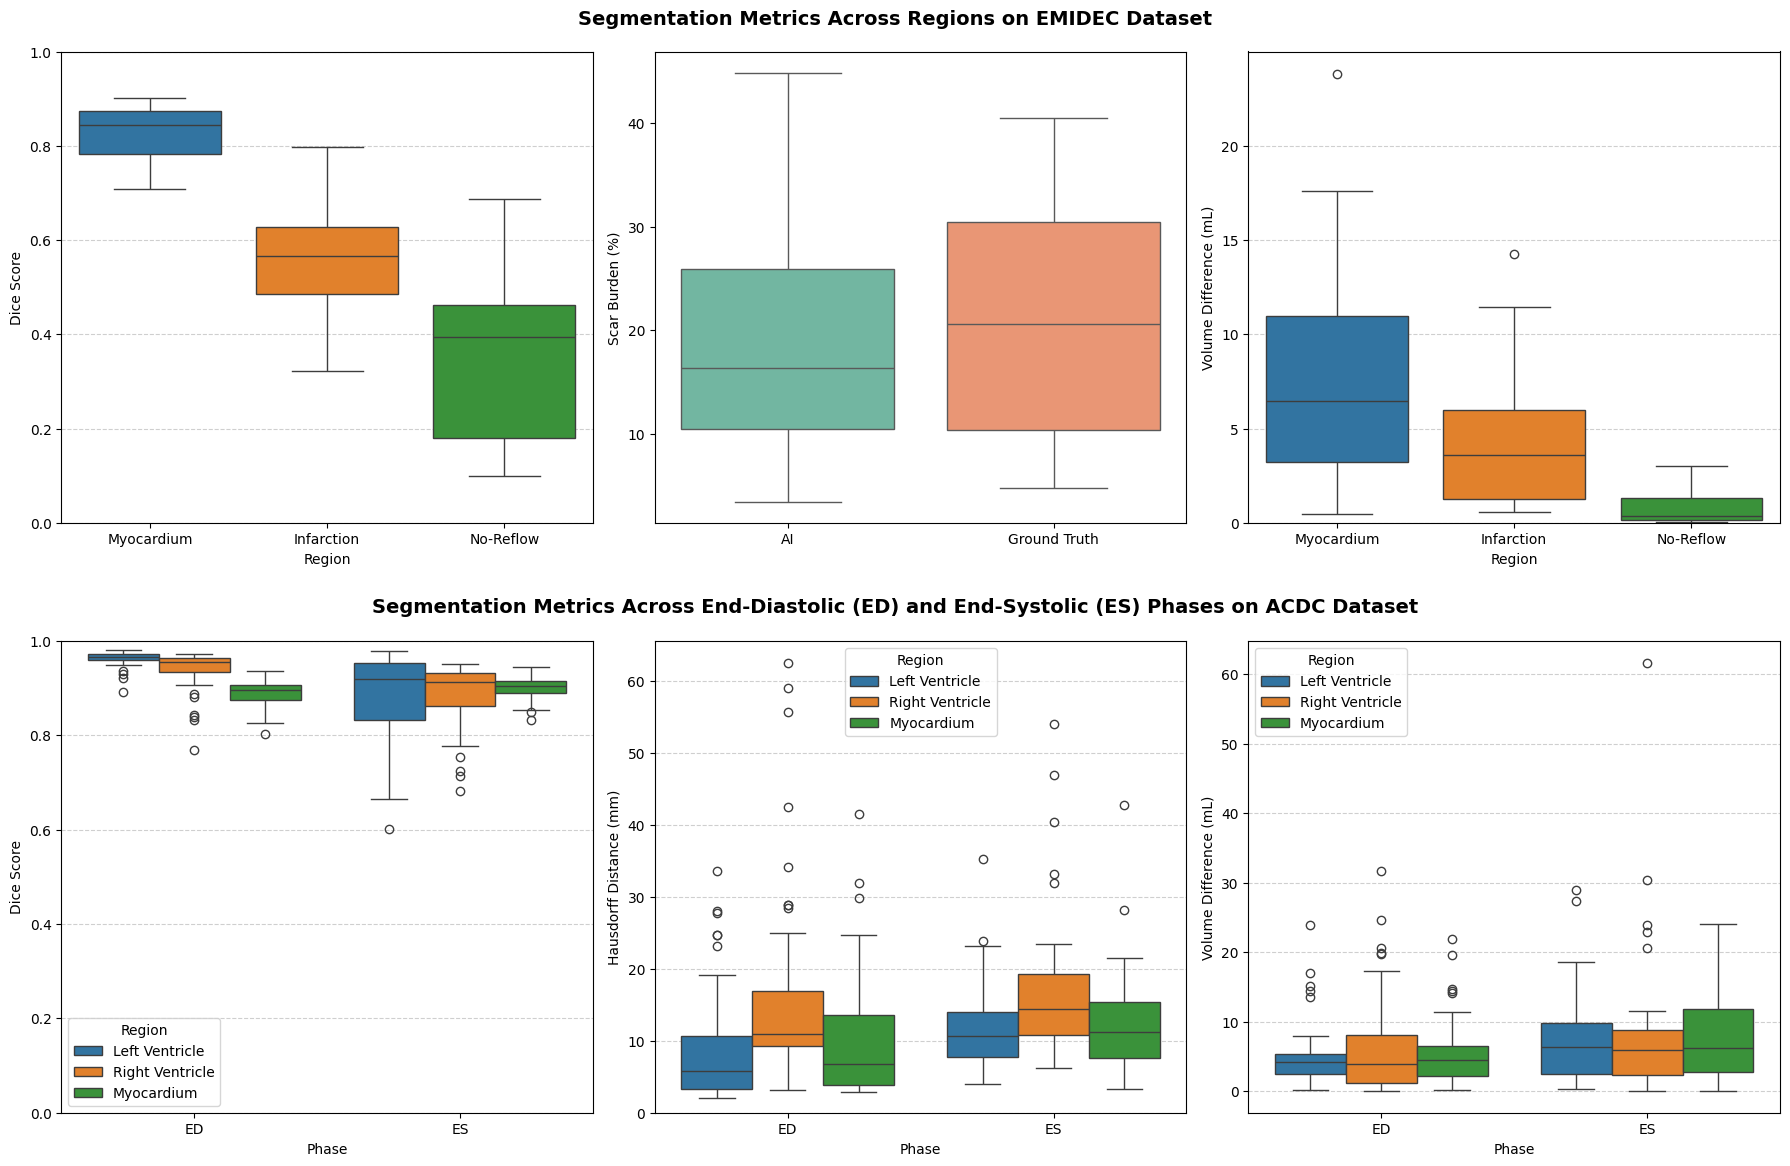

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Create a single figure with 2 rows × 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# ==========================================================
# === Row 1: EMIDEC dataset
# ==========================================================
metrics_emidec = ['Dice', 'Vol_Difference', 'Volume Error']
titles_emidec = ['Dice Score', 'Volume Difference Rate(%)', 'Volume Difference (mL)']

for ax, metric, title in zip(range(len(axes[0])), metrics_emidec, titles_emidec):
    if ax != 1:
        ax = axes[0][ax]
        subset = df_emidec[df_emidec['Metric'] == metric]
        
        sns.boxplot(
            x='Region',
            y='Value',
            hue='Region',
            data=subset,
            ax=ax,
            showfliers=True,  # optional: hides outliers for cleaner look
            legend=False
        )
        
        # ax.set_title(title)
        ax.set_xlabel('Region')
        ax.set_ylabel(metric)
        ax.grid(axis='y', linestyle='--', alpha=0.6)
        
        if metric == 'Dice':
            ax.set_ylim(0, 1)
            ax.set_ylabel('Dice Score')
        elif metric == 'Vol_Difference':
            ax.set_ylim(0, None)
            ax.set_ylabel('Difference Rate(%)')
        elif metric == 'Volume Error':
            ax.set_ylim(0, None)
            ax.set_ylabel('Volume Difference (mL)')

# Add EMIDEC subtitle manually
fig.text(0.5, 0.96, 'Segmentation Metrics Across Regions on EMIDEC Dataset',
         ha='center', va='center', fontsize=14, fontweight='bold')
########################### plot the ax[0][1]
ax = axes[0][1]
gt = gt_volume[gt_volume["Volume_Infarction"] != 0]
gt_ratio = gt["Volume_Infarction"] / gt["Volume_Myocardium"] * 100

pred = result_emidec[result_emidec["Volume_Infarction"] != 0]
pred_ratio = pred["Volume_Infarction"] / pred["Volume_Myocardium"] * 100
# Ensure same indexing if needed (optional: align by patient ID)
# Here we assume they are already paired or independent for visualization

# Create a DataFrame for easy plotting with seaborn
data = pd.DataFrame({
    'AI': pred_ratio,
    'Ground Truth': gt_ratio,

})
data_melted = data.melt(var_name='', value_name='Infarction / Myocardium Ratio')
sns.boxplot(x='', y='Infarction / Myocardium Ratio', data=data_melted, palette="Set2", ax=ax)
# make the boxplot of gt_volume["Volume_Infarction"] / gt_volume["Volume_Myocardium"] and result_emidec["Volume_Infarction"] / result_emidec["Volume_Myocardium"]
# ax.set_title("Scar Burden")
ax.set_ylabel('Scar Burden (%)')



###############################################################
# ==========================================================
# === Row 2: ACDC dataset
# ==========================================================
metrics_acdc = ['Dice', 'HD', 'Err']
titles_acdc = ['Dice Score', 'Hausdorff Distance (mm)', 'Volume Difference (mL)']

for ax, metric, title in zip(axes[1], metrics_acdc, titles_acdc):
    subset = df_long[df_long['Metric'] == metric]
    
    sns.boxplot(
        x='Phase',
        y='Value',
        hue='Region',
        data=subset,
        ax=ax,
        showfliers=True,
        legend=True
    )
    
    # ax.set_title(title)
    ax.set_xlabel('Phase')
    ax.set_ylabel(metric)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    
    if metric == 'Dice':
        ax.set_ylim(0, 1)
        ax.set_ylabel('Dice Score')
    elif metric == 'HD':
        ax.set_ylim(0, None)
        ax.set_ylabel('Hausdorff Distance (mm)')
    elif metric == 'Err':
        ax.set_ylabel('Volume Difference (mL)')

plt.subplots_adjust(hspace=0.9, bottom=0.12)

# Add ACDC subtitle manually
fig.text(0.5, 0.47, 'Segmentation Metrics Across End-Diastolic (ED) and End-Systolic (ES) Phases on ACDC Dataset',
         ha='center', va='center', fontsize=14, fontweight='bold')

# ==========================================================
# === Final formatting
# ==========================================================

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(hspace=0.25)
plt.savefig("figures/segmentation_metrics.png", dpi=300)

plt.show()


In [27]:
ED_image.shape

(216, 256, 8)

In [46]:
# make the crop center of the image 128
image = ED_image[ED_image.shape[0]//2-64:ED_image.shape[0]//2+64, ED_image.shape[1]//2-64:ED_image.shape[1]//2+64, :]
mask = ED_mask[ED_mask.shape[0]//2-64:ED_mask.shape[0]//2+64, ED_mask.shape[1]//2-64:ED_mask.shape[1]//2+64, :]
seg = ED_seg[ED_seg.shape[0]//2-64:ED_seg.shape[0]//2+64, ED_seg.shape[1]//2-64:ED_seg.shape[1]//2+64, :]

def plot_image_mask_z(image, mask, padded_image, padded_mask, z):
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(image[..., z], cmap="gray")
    ax[0].set_title("Image gt")
    # ax[0].imshow(mask[..., z], cmap="jet", alpha=0.3)
    ax[1].imshow(padded_image[..., z], cmap="gray", alpha=0.7)
    ax[1].set_title("Image predict")
    ax[1].imshow(padded_mask[..., z], cmap="jet", alpha=0.5, vmin=0, vmax=4)

    ax[2].imshow(padded_image[..., z], cmap="gray", alpha=0.7)
    ax[2].imshow(mask[..., z], cmap="jet", alpha=0.5)
    ax[2].set_title("Mask gt")
    # off the axis
    ax[0].axis('off')
    ax[1].axis('off')


interact(lambda z: plot_image_mask_z(image, mask, image, seg, z), z=(0, ED_image.shape[-1] - 1))

interactive(children=(IntSlider(value=3, description='z', max=7), Output()), _dom_classes=('widget-interact',)…

<function __main__.<lambda>(z)>

# predict Table 2 dataset

In [ ]:
model_name = "tiramisu_emidec.pt" # "tiramisu_emidec.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_acdc = torch.load(model_name, weights_only=False)
model_acdc.eval()
model_acdc = model_acdc.to(device)

def preprocess_data_table2(image_nrrd_path):
    data = {}
    patient_image = nrrd.read(image_nrrd_path)
    image = patient_image[0]
    image = min_max_normalize(image)

    resized_image, restore_info = crop_resize_image(image, 256)
    # padded_mask = pad_background_with_index(mask, crop_index, padded_index, dim2pad=cfg.DATA.DIM2PAD)
    data["restore_info"] = restore_info
    batch_images = []
    for i in range(resized_image.shape[-1]):
        slice_inputs = resized_image[..., i : i + 1]  # shape (224, 224, 1)
        slices_image = torch.from_numpy(slice_inputs.transpose(-1, 0, 1))  # shape (1, 224, 224)
        batch_images.append(slices_image)

    batch_images = torch.stack(batch_images).float()  # shape (9,1, 224, 224)
    data["image"] = batch_images
    return data
    
table2_path = "Tables 2/Tables/*/"
list_test_image = natsorted([x for x in glob.glob("Tables 2/Tables/*/*.nrrd") if "seg" not in x])
list_test_mask = natsorted([x for x in glob.glob("Tables 2/Tables/*/*seg.nrrd")])

print(len(list_test_image), len(list_test_mask))


64 64


In [ ]:
# create folder to save the predicted masks
import nrrd
csv_file = f"csv_files/result_table2_{model_name}.csv"
f = open(csv_file, mode="w")
writer = csv.DictWriter(f, fieldnames=["patient_name", "Dice"])
writer.writeheader()
os.makedirs("predicted_table2_data_emidec_model", exist_ok=True)
os.makedirs("predicted_table2_data_acdc_model", exist_ok=True)

for index in range(len(list_test_image)):
    if "42_PC" in list_test_image[index]:

        image = nrrd.read(list_test_image[index])[0]
        image_info = nrrd.read(list_test_image[index])[1]
        data = preprocess_data_table2(list_test_image[index])

        # seg = predict_data(data, segmenter, patient=patient, mvo=is_MVO, task=task).astype(np.uint8)
        num_classes = 4 if model_name == "tiramisu_acdc.pt" else 5
        seg = predict_data_model(data, model_acdc, num_classes=num_classes).astype(np.uint8)
        # give label 1, 3, 4 to 0
        seg[seg == 1] = 0
        seg[seg == 3] = 0
        seg[seg == 4] = 0
        # give label 2 to 1
        seg[seg == 2] = 1
        # write the predicted mask to the a nrrd file with image_info
        # and make name of the file is like this 1 - PGF/34 de_high res PSIR EC_PSIR_tiramisu.nrrd
        name_predict = list_test_image[index].split("/")[-2:]
        name_predict = "/".join(name_predict).replace(".nrrd", "_tiramisu_seg.nrrd")
        # make folder dir 1-PGF to save the predicted mask
        if model_name == "tiramisu_acdc.pt":
            os.makedirs(f"predicted_table2_data_acdc_model/{name_predict.split('/')[0]}", exist_ok=True)
            nrrd.write(f"predicted_table2_data_acdc_model/{name_predict}", seg, image_info)
        else:
            os.makedirs(f"predicted_table2_data_emidec_model/{name_predict.split('/')[0]}", exist_ok=True)
            nrrd.write(f"predicted_table2_data_emidec_model/{name_predict}", seg, image_info)
            
        print("write predicted mask to ", name_predict)

        mask = nrrd.read(list_test_mask[index])[0]
        dice = dice_volume_ACDC(mask, seg, class_index=1)
        writer.writerow({"patient_name": list_test_image[index].split("/")[-2], "Dice": dice})

    
    # break
f.close()

write predicted mask to  42_PCF/32 de_high res PSIR EC_PSIR_tiramisu_seg.nrrd


In [ ]:
def plot_image_mask_z(image, mask, padded_image, padded_mask, z):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image[..., z], cmap="gray")
    ax[0].set_title("Image gt")
    ax[0].imshow(mask[..., z], cmap="jet", alpha=0.3)
    ax[1].imshow(padded_image[..., z], cmap="gray")
    ax[1].set_title("Image predict")
    ax[1].imshow(padded_mask[..., z], cmap="jet", alpha=0.3)
    # off the axis
    ax[0].axis('off')
    ax[1].axis('off')


interact(lambda z: plot_image_mask_z(image, mask, image, seg, z), z=(0, image.shape[-1] - 1))

interactive(children=(IntSlider(value=7, description='z', max=15), Output()), _dom_classes=('widget-interact',…

<function __main__.<lambda>(z)>